# Normalizing flows to approximate complicated distributions

Approximating a complicated posterior distribution with a gaussian generally makes computation tractable but leads to an underestimation of the variance and may simply be completely off when the true distribution is far from being a gaussian (e.g. multimodal, skewed, ...).


### An example of multimodal distribution
Here, we will reproduce the example of 6.1 in the paper to create a 2D multimodal distribution that wouldn't be well approximated by a gaussian.

In [0]:
import torch.nn as nn
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
import matplotlib.pyplot as plt
import numpy as np

def u1(z):
    return 1/2 * ((np.linalg.norm(z, ord=2) - 2)/.4)**2 - np.log(np.exp(-1/2*((z[0] - 2)/.6)**2) + np.exp(-1/2*((z[0] + 2)/.6)**2))

In [0]:
def batch_u1(z):
    z0 = z.select(dim=1, index=0)
    return 1/2 * ((torch.norm(z, p=2, dim=1) - 2)/.4)**2 - torch.log(torch.exp(-1/2*((z0 - 2)/.6)**2) + torch.exp(-1/2*((z0 + 2)/.6)**2))

In [0]:
x = np.random.normal(size=(10, 2))

In [0]:
batch_u1(torch.tensor(x))

tensor([ 5.0145,  2.9990,  2.9172,  1.8799,  2.4315, 12.9660,  1.0053, 10.7402,
         2.0085,  6.7505], dtype=torch.float64)

In [0]:
for e in x:
    print(u1(e))

5.014495274832825
2.9989930888637915
2.9171756395805484
1.8799138837818696
2.4315166161179382
12.966039876246278
1.0053070548791263
10.74024493990563
2.0085424261591163
6.750450851417078


In [0]:
%%time
Z1 = np.linspace(-6, 6, 1000)
Z2 = np.linspace(-6, 6, 1000)
Z = []
for z1 in Z1:
    Z.append([])
    for z2 in Z2:
        Z[-1].append(np.exp(-u1([z2, z1])))
Z = np.array(Z)
print(Z.shape)

(1000, 1000)
CPU times: user 14.9 s, sys: 107 ms, total: 15 s
Wall time: 14.9 s


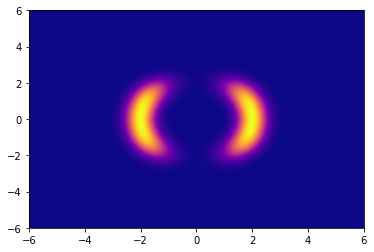

In [0]:
plt.contourf(Z1, Z2, Z, levels=200, cmap="plasma")

Due to the multimodality of this distribution, we cannot approximate it properly using a gaussian variable (or even a mixture of gaussians which wouldn't be able to capture these moon shapes).

### Approximation using planar flows
We will use planar flows to show how this distribution can be pretty well approximated using normalizing flows. We modify the algorithm a bit for this task as we only need a flow without the inference and generative networks. In this case, we try to minimize the KL divergence between the distribution created by the flow and the true distribution defined above. With the notations of the paper using Planar Flows, this corresponds to:
$$
\begin{align}
KL[q_K(z)||p(z)] &= E_{z_K \sim q_K(z)} [\ln q_K(z_K) - \ln p(z_K)] \\
&= E_{z_0 \sim q_0(z)} [\ln q_0(z_0) - \sum_k \ln|1+u_k^T\psi_k(z_{k-1})|  - (-U(f_1(f_2(..f_K(z_0)))) - \ln(Z))] \\
&= E_{z_0 \sim q_0(z)} [\ln q_0(z_0) - \sum_k \ln|1+u_k^T\psi_k(z_{k-1})| + U(f_1(f_2(..f_K(z_0)))) + \ln(Z)]\\
&= E_{z_0 \sim q_0(z)} [U(f_1(f_2(..f_K(z_0))))) - \sum_k \ln|1+u_k^T\psi_k(z_{k-1})|] + cst
\end{align}
$$

where $cst$ doesn't depend on the parameters of the flow. The computation of this expectation is then done through Monte Carlo sampling where the number of Monte Carlo samples is the batch size. 

Let's note that we have also created a full implementation of the paper including an inference and a generative network that we provide in another notebook.

In [0]:
def tensorlist_to_tensor(l):
    return torch.cat([t.unsqueeze(0) for t in l])

In [0]:
class Flow(nn.Module):
    def __init__(self, K, D):
        super().__init__()
        self.K = K
        self.linear_layers = nn.ModuleList([nn.Linear(D, 1) for _ in range(K)])
        self.u_vectors = nn.Parameter(data=torch.randn(K, D))

    
    def forward(self, z):
        all_zs = [z]
        all_u_times_psis = []
        for linear_layer, u_vector in zip(self.linear_layers,
                                          self.u_vectors):
            z_prev = all_zs[-1]
            linear_layer_output = linear_layer(z_prev)
            tanh_output = torch.tanh(linear_layer_output)
            all_zs.append((z_prev + u_vector * tanh_output))
            all_u_times_psis.append(torch.sum(u_vector * (1 - tanh_output**2) * linear_layer.weight.flatten(), dim=1))
        return all_zs, tensorlist_to_tensor(all_u_times_psis).permute(1, 0)

In [0]:
from torch.distributions.multivariate_normal import MultivariateNormal

class CompleteFlowNet(nn.Module):
    def __init__(self, D, K, init_mu=None, init_comat=None):
        super().__init__()
        if init_mu is None:
            init_mu = torch.zeros(D).cuda()
        if init_comat is None:
            init_comat = torch.eye(D).cuda()
        self.init_dist = MultivariateNormal(loc=init_mu,
                                            covariance_matrix=init_comat)
        self.flow_net = Flow(K, D)
    
    def _sample(self, batch_size):
        z0 = self.init_dist.sample([batch_size])
        all_zs, all_u_times_psis = self.flow_net(z0)
        z_K = all_zs[-1]
        return z_K, z0, all_u_times_psis

    def forward(self, batch_size):
        z_K, z0, all_u_times_psis = self._sample(batch_size)

        log_flow = torch.mean(torch.sum(torch.log(1e-7 + torch.abs(1 + all_u_times_psis)), dim=1))
        energy = torch.mean(batch_u1(z_K))

        loss = -log_flow + energy
        return loss, log_flow, energy

Training this flow for 100,000 epochs using the following code gives us the results below. We trained it in two times to check intermediary results, so the following print statements corresponds to the last 50,000 epochs of the training.

In [0]:
import time

complete_flow_net = CompleteFlowNet(K=32, D=2)
complete_flow_net.to(device);
optimizer = torch.optim.Adam(complete_flow_net.parameters(), lr=1e-4)

num_epochs = 50000
batch_size = 1000
t0 = time.time()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss, log_flow, energy = complete_flow_net(batch_size)
    loss.backward()
    optimizer.step()
    t = time.time() - t0
    if epoch % 1000 == 0 or epoch == num_epochs - 1 or epoch == 200:
        print(f'Epoch {epoch+1} Loss {loss:.3f} Log_flow {log_flow:.3f} Energy {energy:.3f} ({t:.3f}s elapsed since beginning)')

Epoch 1 Loss 0.568 Log_flow 0.260 Energy 0.828 (0.042s elapsed since beginning)
Epoch 201 Loss 0.498 Log_flow 0.263 Energy 0.761 (6.408s elapsed since beginning)
Epoch 1001 Loss 0.577 Log_flow 0.265 Energy 0.842 (32.370s elapsed since beginning)
Epoch 2001 Loss 0.535 Log_flow 0.255 Energy 0.790 (64.169s elapsed since beginning)
Epoch 3001 Loss 0.593 Log_flow 0.231 Energy 0.824 (96.456s elapsed since beginning)
Epoch 4001 Loss 0.557 Log_flow 0.244 Energy 0.801 (127.719s elapsed since beginning)
Epoch 5001 Loss 0.663 Log_flow 0.175 Energy 0.838 (160.613s elapsed since beginning)
Epoch 6001 Loss 0.591 Log_flow 0.247 Energy 0.839 (193.259s elapsed since beginning)
Epoch 7001 Loss 0.541 Log_flow 0.284 Energy 0.825 (225.900s elapsed since beginning)
Epoch 8001 Loss 0.553 Log_flow 0.270 Energy 0.824 (258.129s elapsed since beginning)
Epoch 9001 Loss 0.561 Log_flow 0.230 Energy 0.791 (290.346s elapsed since beginning)
Epoch 10001 Loss 0.533 Log_flow 0.301 Energy 0.833 (323.149s elapsed since b

We can then sample from the approximating distribution and run a Kernel Density Estimation to plot the results properly.

In [0]:
samples, _, _ = complete_flow_net._sample(10000)
samples = samples.cpu().detach().numpy()

In [0]:
samples.shape

(10000, 2)

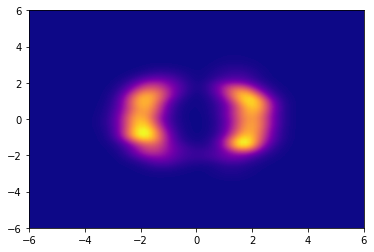

In [0]:
import scipy.stats as st

x = samples[:, 0]
y = samples[:, 1]
xmin, xmax = -6, 6
ymin, ymax = -6, 6

# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

plt.contourf(xx, yy, f, cmap='plasma', levels=200)

We can see that this is pretty close to the true distribution we are trying to approximate.

### Fail case
The training of these flows is actually not trivial and requires a lot of hyperparameter tuning. Having bad hyper parameters can lead to pretty bad results. Here, we explore what happens if our Flow is too shallow (having K=2). Again we trained for 100,000 epochs but the print statements are only for the 50,000 last ones as we trained the flow in two times.

In [0]:
import time

complete_flow_net = CompleteFlowNet(K=2, D=2)
complete_flow_net.to(device);
optimizer = torch.optim.Adam(complete_flow_net.parameters(), lr=1e-4)

num_epochs = 50000
batch_size = 1000
t0 = time.time()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss, log_flow, energy = complete_flow_net(batch_size)
    loss.backward()
    optimizer.step()
    t = time.time() - t0
    if epoch % 1000 == 0 or epoch == num_epochs - 1 or epoch == 200:
        print(f'Epoch {epoch+1} Loss {loss:.3f} Log_flow {log_flow:.3f} Energy {energy:.3f} ({t:.3f}s elapsed since beginning)')

Epoch 1 Loss 2.302 Log_flow 0.373 Energy 2.675 (0.008s elapsed since beginning)
Epoch 201 Loss 2.434 Log_flow 0.382 Energy 2.816 (0.739s elapsed since beginning)
Epoch 1001 Loss 2.447 Log_flow 0.391 Energy 2.838 (3.425s elapsed since beginning)
Epoch 2001 Loss 2.269 Log_flow 0.400 Energy 2.669 (7.105s elapsed since beginning)
Epoch 3001 Loss 2.372 Log_flow 0.388 Energy 2.761 (10.791s elapsed since beginning)
Epoch 4001 Loss 2.289 Log_flow 0.363 Energy 2.651 (14.591s elapsed since beginning)
Epoch 5001 Loss 2.325 Log_flow 0.411 Energy 2.736 (18.592s elapsed since beginning)
Epoch 6001 Loss 2.280 Log_flow 0.425 Energy 2.705 (22.170s elapsed since beginning)
Epoch 7001 Loss 2.348 Log_flow 0.333 Energy 2.681 (25.716s elapsed since beginning)
Epoch 8001 Loss 2.301 Log_flow 0.392 Energy 2.694 (29.410s elapsed since beginning)
Epoch 9001 Loss 2.313 Log_flow 0.423 Energy 2.736 (32.769s elapsed since beginning)
Epoch 10001 Loss 2.230 Log_flow 0.397 Energy 2.627 (36.450s elapsed since beginning)

In [0]:
samples, _, _ = complete_flow_net._sample(10000)
samples = samples.cpu().detach().numpy()

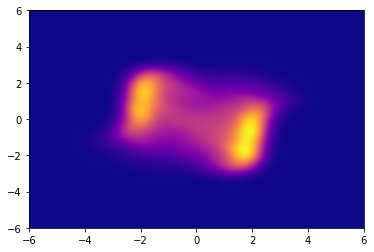

In [0]:
import scipy.stats as st

x = samples[:, 0]
y = samples[:, 1]
xmin, xmax = -6, 6
ymin, ymax = -6, 6

# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

plt.contourf(xx, yy, f, cmap='plasma', levels=200)

We see that we completely fail at approximating the true distribution because the flow is too shallow for the task.